## Single Decision Tree (SDT) Benchmark

H2O cloud is inicialized before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.


In [18]:
import sys
sys.path.append("h2o-py/build/main") # path to h2o build

print(sys.path)

['/Users/yuliia/work/h2o-3', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/yuliia/work/h2o-3/venv/lib/python3.9/site-packages', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/site-packages', 'h2o-py/build/main', 'h2o-py/build/main']


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2OSingleDecisionTreeEstimator
from h2o.estimators import H2ORandomForestEstimator
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Notebook parameters
attempt_per_thread = 1 # number of runs of the algorithm in the thread # todo - change to 5
max_depth = 5 
threds = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
DATA_PATH = "/Users/yuliia/work/h2o-3/benchmark_data/"


In [16]:
def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    h2o.connect()
    hf = h2o.H2OFrame(data)
    start = time.time()
    SDT_h2o = H2OSingleDecisionTreeEstimator(model_id = "single_decision_tree.hex", max_depth=max_depth)
    SDT_h2o.train(training_frame = hf, y='label')
    end = time.time()
    sdt_time = end - start
    print(f"SDT Time: {sdt_time}s")
    start = time.time()
    DRF_h2o = H2ORandomForestEstimator(model_id = "random_forest.hex", ntrees = 1, max_depth = max_depth, 
                                       sample_rate=1, score_tree_interval=2)
    hf['label'].asfactor()
    DRF_h2o.train(training_frame = hf, y='label')
    end = time.time()
    drf_time = end - start
    print(f"DRF Time: {drf_time}s")
    
    predictions_sdt = SDT_h2o.predict(hf)
    predictions_drf = DRF_h2o.predict(hf)
    
    print(predictions_sdt.type)
    if start_cluster:
        h2o.cluster().shutdown()
        time.sleep(10)
    return sdt_time, drf_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_sdt = []
    all_times_num_drf = []
    for nthreads in threds:
        times_sdt = []
        times_drf = []
        for i in range(attempt_per_thread):
            sdt_time, drf_time = train_models(nthreads, data, start_cluster)
            times_sdt.append(sdt_time)
            times_drf.append(drf_time)
        print(f"SDT {np.mean(times_sdt)}s")
        print(f"DRF {np.mean(times_drf)}s")
        all_times_num_sdt.append(times_sdt)
        all_times_num_drf.append(times_drf)
        all_times.append(f"thread {nthreads} - SDT {np.mean(times_sdt)}s and DRF {np.mean(times_drf)}s")

    sdt_means = dict()
    drf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - SDT = {np.mean(all_times_num_sdt[i])}, DRF = {np.mean(all_times_num_drf[i])}")
        sdt_means[nthreads] = np.mean(all_times_num_sdt[i])
        drf_means[nthreads] = np.mean(all_times_num_drf[i])
    
    return sdt_means, drf_means
        
    
def plot_result(sdt_means, drf_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in sdt_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_drf = {"x":[], "y": [], "label":[]}
    for label, coord in drf_means.items():
        data_drf["x"].append(label)
        data_drf["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-o', label="SDT", linewidth=3)
    plt.plot(data_drf['x'], data_drf['y'], '-o', label="DRF", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Single Decision Tree - training benchmark\nModel: max_depth = {max_depth}")
    plt.savefig(f"h2o-scale-perf.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage


### Big data and small dimension

In [17]:
X = pd.read_csv(DATA_PATH + "Dataset1_train.csv")
sdt_time1, drf_time1 = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,35 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_yuliia_82aqco
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.499 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,35 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_yuliia_82aqco
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.499 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |

/Users/yuliia/work/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
SDT Time: 0.9183011054992676s
drf Model Build progress: |

/Users/yuliia/work/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.0399630069732666s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 0.9183011054992676s
DRF 1.0399630069732666s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp3t8o_240
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp3t8o_240/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp3t8o_240/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_yuliia_r1oz7l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_yuliia_r1oz7l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.3876049518585205s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.5478038787841797s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.3876049518585205s
DRF 2.5478038787841797s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpxn_uk0o1
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpxn_uk0o1/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpxn_uk0o1/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_yuliia_289cb5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_yuliia_289cb5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.3705079555511475s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.7473669052124023s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.3705079555511475s
DRF 2.7473669052124023s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpmy9kuesv
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpmy9kuesv/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpmy9kuesv/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_yuliia_ka9b6n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_yuliia_ka9b6n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.408784866333008s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.3583719730377197s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.408784866333008s
DRF 2.3583719730377197s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmphle695og
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmphle695og/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmphle695og/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_yuliia_7eib53
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_yuliia_7eib53
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.3705830574035645s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.1372690200805664s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.3705830574035645s
DRF 2.1372690200805664s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpf18o56cv
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpf18o56cv/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpf18o56cv/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_yuliia_5w6lkp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_yuliia_5w6lkp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.382737159729004s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.8678603172302246s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.382737159729004s
DRF 1.8678603172302246s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpl912826x
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpl912826x/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpl912826x/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_yuliia_fapts7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_yuliia_fapts7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.21657395362854s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 3.0292348861694336s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.21657395362854s
DRF 3.0292348861694336s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpbinrhj8k
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpbinrhj8k/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpbinrhj8k/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_yuliia_gofmyh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_yuliia_gofmyh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.6268322467803955s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.8862531185150146s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.6268322467803955s
DRF 1.8862531185150146s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp6u4su6jg
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp6u4su6jg/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp6u4su6jg/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_yuliia_bpjrkl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_yuliia_bpjrkl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.6700799465179443s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.4717860221862793s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.6700799465179443s
DRF 1.4717860221862793s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp7uj60p_c
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp7uj60p_c/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp7uj60p_c/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_yuliia_st0e8z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_yuliia_st0e8z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.6429388523101807s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.4609599113464355s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 2.6429388523101807s
DRF 1.4609599113464355s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpaf016bss
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpaf016bss/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpaf016bss/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_yuliia_43t3os
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_yuliia_43t3os
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 3.651746988296509s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.5329573154449463s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 3.651746988296509s
DRF 2.5329573154449463s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpyd59hcml
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpyd59hcml/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpyd59hcml/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_yuliia_qqq3k1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_yuliia_qqq3k1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 6.143235206604004s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.4093220233917236s
sdt prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0
0
1
0
1
0
1
1
1
1


<bound method H2OFrame.type of >
SDT 6.143235206604004s
DRF 1.4093220233917236s
12 - SDT = 0.9183011054992676, DRF = 1.0399630069732666
11 - SDT = 2.3876049518585205, DRF = 2.5478038787841797
10 - SDT = 2.3705079555511475, DRF = 2.7473669052124023
9 - SDT = 2.408784866333008, DRF = 2.3583719730377197
8 - SDT = 2.3705830574035645, DRF = 2.1372690200805664
7 - SDT = 2.382737159729004, DRF = 1.8678603172302246
6 - SDT = 2.21657395362854, DRF = 3.0292348861694336
5 - SDT = 2.6268322467803955, DRF = 1.8862531185150146
4 - SDT = 2.6700799465179443, DRF = 1.4717860221862793
3 - SDT = 2.6429388523101807, DRF = 1.4609599113464355
2 - SDT = 3.651746988296509, DRF = 2.5329573154449463
1 - SDT = 6.143235206604004, DRF = 1.4093220233917236


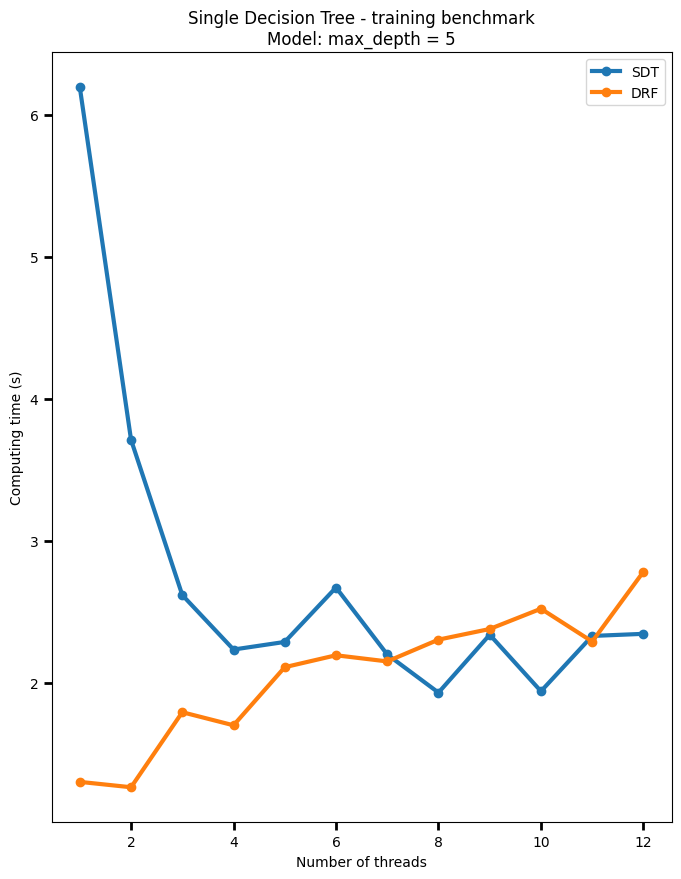

In [8]:
plot_result(sdt_time1, drf_time1)

###### Big data and big dimension

In [9]:
X = pd.read_csv(DATA_PATH + "HIGGS_train_limited1.csv")
sdt_time2, drf_time2 = run_benchmark(X)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yuliia/work/h2o-3/benchmark_data/HIGGS_train_limited1.csv'

In [ ]:
plot_result(sdt_time2, drf_time2)

## Evaluation Stage

In [ ]:
def run_predict(SDT_model, DRF_model, test):
    start = time.time()
    SDT_model.predict(test)
    end = time.time()
    sdt_time = end - start
    print(f"SDT Time: {sdt_time}s")
    start = time.time()
    DRF_model.predict(test)
    end = time.time()
    drf_time = end - start
    print(f"DRF Time: {drf_time}s")    
    return sdt_time, drf_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_sdt = []
    all_times_num_drf = []
    for nthreads in threds:
        times_sdt = []
        times_drf = []
        h2o.init(nthreads=nthreads)     
        train = h2o.H2OFrame(train_data)    
        test = h2o.H2OFrame(test_data)
        SDT_model = H2OSingleDecisionTreeEstimator(model_id = "single_decision_tree.hex", max_depth=max_depth)
        SDT_model.train(training_frame = train, y='label')
        DRF_model = H2ORandomForestEstimator(model_id="random_forest.hex", ntrees=1, max_depth=max_depth,
                                             sample_rate=1, score_tree_interval=2)
        train['label'].asfactor()
        DRF_model.train(training_frame = train, y='label')
        for i in range(attempt_per_thread):
            sdt_time, drf_time = run_predict(SDT_model, DRF_model, test)
            times_SDT.append(SDT_time)
            times_DRF.append(DRF_time)
        h2o.cluster().shutdown()
        print(f"SDT {np.mean(times_sdt)}s")
        print(f"DRF {np.mean(times_drf)}s")
        all_times_num_sdt.append(times_sdt)
        all_times_num_drf.append(times_drf)
        all_times.append(f"thread {nthreads} - SDT {np.mean(times_sdt)}s and DRF {np.mean(times_drf)}s")
        
        
    sdt_means = dict()
    drf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - SDT = {np.mean(all_times_num_sdt[i])}, DRF = {np.mean(all_times_num_drf[i])}")
        sdt_means[nthreads] = np.mean(all_times_num_sdt[i])
        drf_means[nthreads] = np.mean(all_times_num_drf[i])

    return sdt_means, drf_means 

def plot_predict(SDT_means, DRF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in SDT_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_drf = {"x":[], "y": [], "label":[]}
    for label, coord in DRF_means.items():
        data_drf["x"].append(label)
        data_drf["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="SDT", linewidth=3)
    plt.plot(data_drf['x'], data_drf['y'], '-', label="DRF", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Single Decision Tree - evaluation benchmark\nModel: max_depth = {max_depth}")
    plt.savefig(f"h2o-eval-perf.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [ ]:
# Evaluation stage parameters
X_train = pd.read_csv("smalldata/yuliia/HIGGS_train_limited1.csv")
X_test = pd.read_csv("smalldata/yuliia/HIGGS_test_limited1.csv")
sdt_time3, drf_time3 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(sdt_time3, drf_time3)